In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import scipy.stats as sp
import matplotlib as mtp
#import PQ3_preprocessing as PQ3
mtp.rcParams['pdf.fonttype'] = 42

In [2]:
tcgaDf = pd.read_csv("C:/Data/Lab/Carter_Lab/aneuploidy_data/TCGA_TP_allgene.csv")

#tcellMarker = pd.read_csv("/cellar/users/a53206221/Data/PDL1/Tcell.CDmarkerExp.csv")

CD3_marker = ["CD3D","CD3E","CD3G"]
Bcell_marker = ["CD19","MS4A1"]

tcgaDf["CD3"] = sp.stats.gmean(np.log2(1+tcgaDf[CD3_marker]),axis=1)
tcgaDf["Bcell"]  = sp.stats.gmean(np.log2(1+tcgaDf[Bcell_marker]),axis=1)

C:\Software\Anaconda3\envs\py3_test_env\lib\site-packages\scipy\stats\stats.py:275: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))
C:\Software\Anaconda3\envs\py3_test_env\lib\site-packages\scipy\stats\stats.py:275: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


# Figure 1
    - the heatmap

In [3]:
def heatmap_infiltrate(hpvNegative = False,save = False, DIR = None):
    CD4_Tcell = ["CD3D","CD3E","CD3G","CD4"]
    CD8_Tcell = ["CD3D","CD3E","CD3G","CD8A","CD8B"]
    
    tcgaDf["CD4"] = sp.stats.gmean(np.log2(1 + tcgaDf[CD4_Tcell]),axis=1)
    tcgaDf["CD8"] = sp.stats.gmean(np.log2(1 + tcgaDf[CD8_Tcell]),axis=1)
    
    dict_cor = {"CD3":[],
            "CD8":[],
            "CD4":[],
            "Bcell":[]}

    dict_pval = {"CD3":[],
                 "CD8":[],
                 "CD4":[],
                 "Bcell":[]}
    disease_type = ["HNSC","non-TNBC","SKCM","READ","LUAD","LUSC","COAD","TNBC","BLCA","CESC","LIHC","GBM"]
    for disease in disease_type:

        if disease == "non-TNBC":
            tmp = tcgaDf[tcgaDf.disease == "BRCA"].drop_duplicates()
            tmp = tmp[[x not in tnbc_ids for x in tmp["patient_id"]]]
            
        elif disease == "TNBC":
            tmp = tcgaDf[tcgaDf.disease == "BRCA"].drop_duplicates()
            tmp = tmp[[x in tnbc_ids for x in tmp["patient_id"]]]
        
        else:
             tmp = tcgaDf[tcgaDf.disease == disease].drop_duplicates()
        
        for key,celltype in zip(["CD3","CD4","CD8","Bcell"],["CD3","CD4","CD8","Bcell"]):
            test = sp.spearmanr(tmp.TERT, tmp[celltype])
            #print(disease + " --- >" + str(sp.spearmanr(tmp.TERT,tmp.gmeanCD3)))
            dict_cor[key].append(test[0])
            dict_pval[key].append(test[1])
            
    dfMatrix = pd.DataFrame({"CD3":dict_cor["CD3"],
                         "CD4":dict_cor["CD4"],
                         "CD8":dict_cor["CD8"],
                         "Bcell":dict_cor["Bcell"]})
    
    dfMatrix_pvals = pd.DataFrame({"CD3":dict_pval["CD3"],
                         "CD4":dict_pval["CD4"],
                         "CD8":dict_pval["CD8"],
                         "Bcell":dict_pval["Bcell"]})
    
    dfMatrix.index = disease_type
    dfMatrix_pvals.index = disease_type
    
    df_plot = dfMatrix.reset_index().melt(id_vars = ["index"])
    dfMatrix_pvals = dfMatrix_pvals.reset_index().melt(id_vars = ["index"])
    from statsmodels.stats.multitest import multipletests
    df_plot["p_val"] = np.ravel(multipletests(dfMatrix_pvals["value"],method = "fdr_bh")[1])
    
    return df_plot

In [4]:
brca_subtype = pd.read_csv("C:/Data/Lab/Zanetti_Lab/BRCA/nationwidechildrens.org_clinical_patient_brca.txt",sep = "\t")
brca_subtype = brca_subtype.iloc[2:]
brca_subtype["tnbc"] = ["Positive" if x == "Negative" and (y == "Negative" or z == "Negative") else "Negative" for x,y,z in zip(brca_subtype["her2_status_by_ihc"],brca_subtype["er_status_by_ihc"],brca_subtype["pr_status_by_ihc"])]

tnbc_ids = set(brca_subtype[brca_subtype["tnbc"] == "Positive"]["patient_id"])

In [5]:
df_plot = heatmap_infiltrate()

C:\Software\Anaconda3\envs\py3_test_env\lib\site-packages\scipy\stats\stats.py:275: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))
C:\Software\Anaconda3\envs\py3_test_env\lib\site-packages\scipy\stats\stats.py:275: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


In [6]:
# reversed significance level here for convenience (big circle)
df_plot["significance"] = df_plot["p_val"] > 0.05

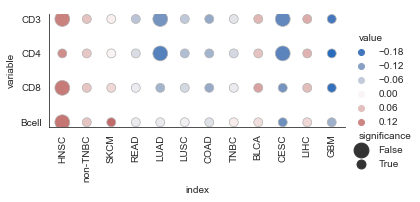

In [7]:
sns.set_style("white")
g = sns.relplot(
    data=df_plot,
    x="index", y="variable", hue="value", size="significance",
    palette="vlag", edgecolor=".7",
    hue_norm = (-.2,.2),
    height=2.1, aspect = 2.3,sizes=(80, 220),
)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
# Tweak the figure to finalize
# reversed significance level here for convenience (big circle)
DIR = "C:/Data/Lab/Zanetti_Lab/Figures/"
plt.savefig(DIR + "fig1.dot.heatmap_x.pdf", bbox_inches = "tight")

# Figure 1B,C
- development of the TERT-immune score
- cox proportional hazard model

In [8]:
def plot_forest_by_tumor(df,diseaseSet = None):
    from lifelines import CoxPHFitter
    cph = CoxPHFitter()
    
    f_dir = "C:/Data/Lab/Zanetti_Lab/HNSC/"
    pfs = pd.read_csv(f_dir+"PFSfile.csv")
    df = pd.merge(pfs, df, on = "patient_id").drop_duplicates()
    if diseaseSet:
        df = df[[x in diseaseSet for x in df.disease.tolist()]]
    score_by_tumor = pd.DataFrame(index = ["score","lower-bound","upper-bound","pval"],columns = df.disease.unique().tolist())
    
    for disease in df.disease.unique().tolist():
        subdf = df[df.disease == disease]
        cph.fit(subdf[["PFS.time","PFS","score"]].dropna(), 'PFS.time', event_col='PFS')
        
        l = cph.confidence_intervals_["95% lower-bound"].values[0]
        h = cph.confidence_intervals_["95% upper-bound"].values[0]
        coef = cph.summary["coef"].values[0]
        
        pval = cph.summary["p"].values[0]
        score_by_tumor[disease] = pd.Series(index = ["score","lower-bound","upper-bound","pval"], data = [coef,l,h,pval])
        
    return score_by_tumor

def forest_plots_cat(df,diseaseSet = None, return_df = False):
    
    from statsmodels.stats.multitest import multipletests
    
    df_plot = plot_forest_by_tumor(df,diseaseSet = diseaseSet)
    df_plot = df_plot.T.sort_values(by = "score")
    df_plot["significant"] = multipletests(df_plot["pval"].tolist(),method = "fdr_bh")[0]
    df_plot["s_color"] = ["k" if x else "#E7C9BC" for x in df_plot["significant"]]
    
    y = list(range(df_plot.shape[0]))
    if diseaseSet:
        L = len(diseaseSet) / 3.2
        W = len(diseaseSet) / 30 + 3
    else:
        L = 9
        W = 4
    plt.figure(figsize = (W,L))
    for i in y:
        plt.plot(df_plot.iloc[i]["score"],i, marker = "o", color = df_plot.iloc[i]["s_color"])
        plt.plot((df_plot.iloc[i]["lower-bound"],
                 df_plot.iloc[i]["upper-bound"]),(i,i),'k|-')
    plt.axvline(x = 0, color = 'k',linestyle = "--")
    plt.yticks(y, df_plot.index.tolist())
    
    if return_df:
        return df_plot

In [9]:
tcgaDf["imm"] = tcgaDf["CD3"] + tcgaDf["Bcell"]

In [10]:
disease_list = ["BRCA","LUSC","LUAD","BLCA","SKCM","LIHC","HNSC","CESC","GBM","COAD","READ"]
def bin_into_cate_2(df, disease_list):
    df_copy = pd.DataFrame({"patient_id":df["patient_id"].tolist()})
    #df = pd.merge(df,tcgaDf[["patient_id","TERT"]], on = "patient_id").drop_duplicates()
    for cat in ["imm","TERT"]: # modified to imm2
        series_concat = pd.Series()
        for disease in disease_list:
            df_tmp = df[df["disease"] == disease]
            df_tmp = df_tmp.groupby("patient_id")[[cat]].mean()
            bins = [-1, np.quantile(df_tmp[cat],q = .3), np.quantile(df_tmp[cat],q = .7),np.inf]
            labels = [1,2,3]
            series_concat = pd.concat([series_concat,pd.cut(df_tmp[cat],bins = bins,labels = labels)])
        series_concat.index.name = "patient_id"
        df_series = pd.DataFrame(series_concat)
        df_series.rename(columns = {0:cat},inplace = True)
        df_copy = pd.merge(df_copy, df_series, on = "patient_id")
    return df_copy

df_score_2 = bin_into_cate_2(tcgaDf,disease_list)

<ipython-input-10-398757741279>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_concat = pd.Series()
<ipython-input-10-398757741279>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_concat = pd.Series()


In [11]:
def PFS_multi_group(df,group,disease,time = None):
    from lifelines import KaplanMeierFitter
    kmf = KaplanMeierFitter()
    from lifelines.statistics import logrank_test
    mtp.rcParams['pdf.fonttype'] = 42
    f_dir = "C:/Data/Lab/Zanetti_Lab/HNSC/"
    pfs=pd.read_csv(f_dir+"PFSfile.csv")
    df=pd.merge(df,pfs[['patient_id','PFS','PFS.time']],on='patient_id')
    df.dropna(subset=['PFS.time','PFS'],inplace=True)
    if time:
        df = df[df["PFS.time"] < time]
    df.drop_duplicates(inplace=True)
    
    groups = list(sorted(df[group].unique()))
    g = [[x == y for x in df[group]] for y in groups]
    T , C = {},{}
    for name, g in zip(groups,g):
        T[name] = df['PFS.time'][g]
        T[name] = np.int32(T[name])
        C[name] = df['PFS'][g]*1
        C[name] = np.int32(C[name])

    fig,ax = plt.subplots(figsize = (6,6),sharex=True,sharey=True)

    results = {}
    n = len(np.unique(groups))
    colors = sns.color_palette(["#01D631", "#0085FB", "#FFAF23"], n_colors=3)
    for name, g, c in zip(groups,g,colors):
        results[name] = kmf.fit(T[name],C[name],label = " groups " + str(name) + " = "+ str(len(df[df[group] == name])))
        kmf.plot(ci_show = False,ax = ax, color = c)
        ax.scatter(x = 'timeline', y = " groups " + str(name) + " = "+ str(len(df[df[group] == name])),
            data = results[name].survival_function_.reset_index(),marker = "|",
                  s = 5)

    plt.title('multi-group survival plot '+ disease)
    plt.xlim([0,time])
    plt.ylim([-0.05,1.05])
    #result = logrank_test(T.astype(np.int), T2.astype(np.int), C.astype(np.int), C2.astype(np.int), alpha=0.95)
    #print(result.p_value)
    return T,C
def plot_multi_survival_for_scoreinterval(df,disease, bins, labels):
    dfplot = df[df.disease == disease]
    #dfplot = dfplot[[ True if x in set([3,6,9,12]) else False for x in dfplot["score"]]]
    dfplot["score_interval"] = pd.cut(dfplot["score"], bins = bins, labels = labels)
    T, C = PFS_multi_group(dfplot,"score_interval",disease,None)
    dfplot["score_interval"] = [np.int(x) for x in dfplot["score_interval"]]
    #median = calcualte_median_score(dfplot,disease,"score_interval",labels)
    return T, C

In [12]:
df_score_2["score"] = df_score_2["imm"].astype(int) + df_score_2["TERT"].astype(int)
pid2disease = dict(zip(tcgaDf["patient_id"],tcgaDf["disease"]))
df_score_2["disease"] = [ pid2disease[x] for x in df_score_2["patient_id"].tolist()]

In [13]:
brca_score = df_score_2[df_score_2["disease"] == "BRCA"]

In [14]:
brca_subtype = pd.read_csv("C:/Data/Lab/Zanetti_Lab/BRCA/nationwidechildrens.org_clinical_patient_brca.txt",sep = "\t")
brca_subtype = brca_subtype.iloc[2:]
brca_subtype["tnbc"] = ["Positive" if x == "Negative" and (y == "Negative" or z == "Negative") else "Negative" for x,y,z in zip(brca_subtype["her2_status_by_ihc"],brca_subtype["er_status_by_ihc"],brca_subtype["pr_status_by_ihc"])]

tnbc_ids = set(brca_subtype[brca_subtype["tnbc"] == "Positive"]["patient_id"])
brca_score["disease"] = ["TNBC" if x in tnbc_ids else "non-TNBC" for x in brca_score["patient_id"]]

<ipython-input-14-7f6f60e3dbfa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brca_score["disease"] = ["TNBC" if x in tnbc_ids else "non-TNBC" for x in brca_score["patient_id"]]


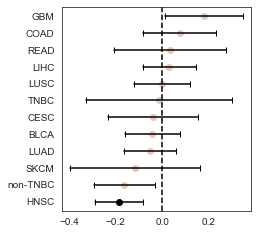

In [15]:
disease_list = ["HNSC","non-TNBC","SKCM","READ","LUAD","LUSC","COAD","TNBC","BLCA","CESC","LIHC","GBM"]
df_score_2_clean = pd.concat([df_score_2[df_score_2["disease"] != "BRCA"], brca_score])
sns.set_style("white")
forest_plots_cat(df_score_2_clean,disease_list)
#f_dir = "C:/Data/Lab/Zanetti_Lab/Figures/"
#plt.savefig(f_dir + "fig1d.forestplot_ordered_score6.pdf",bbox_inchest = "tight")

In [16]:
tmp = pd.DataFrame(df_score_2_clean.groupby("disease")["score"].value_counts())
tmp.columns = ["counts"]
tmp.reset_index(inplace = True)

tmp = tmp.pivot(index = "disease", columns = "score", values = "counts").reset_index()
tmp = tmp.set_index("disease").loc[disease_list].reset_index()

tmp = tmp[[2,3,4,5,6]].T / np.sum(tmp[[2,3,4,5,6]],axis=1)
tmp.columns = disease_list
tmp = tmp.T.reset_index()

<AxesSubplot:title={'center':'counts'}, xlabel='index'>

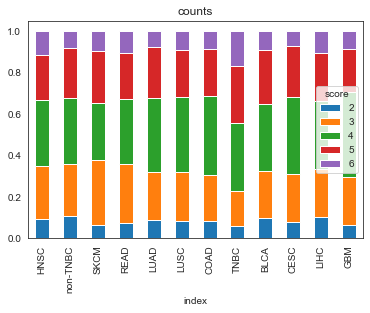

In [17]:
tmp.plot(x='index', kind='bar', stacked=True,
        title='counts')
#plt.savefig("C:/Data/Lab/Zanetti_Lab/Figures/finalize/Figure1/fig1b.stackplot.pdf",bbox_inches = "tight")

# Supplementary Figure 1

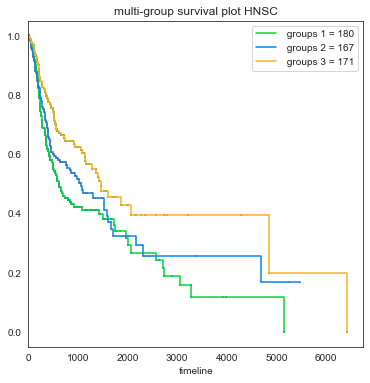

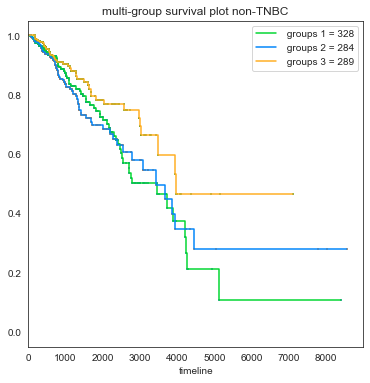

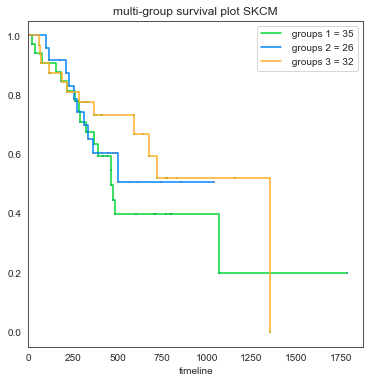

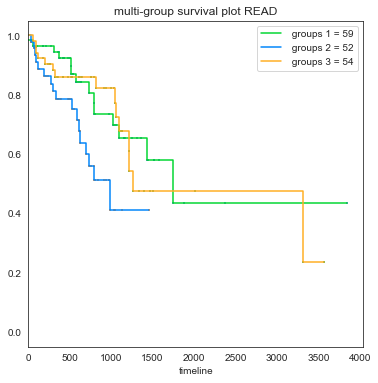

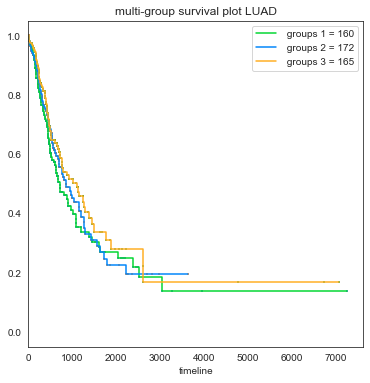

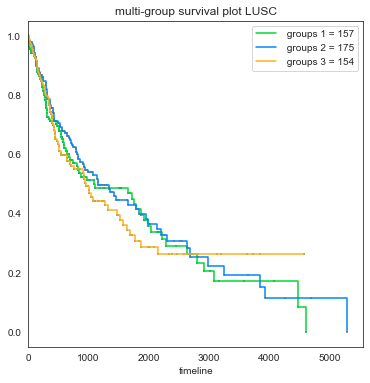

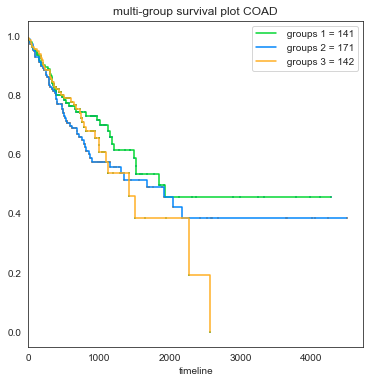

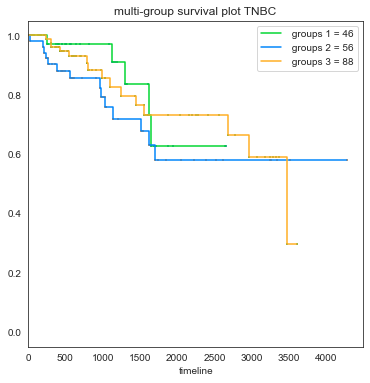

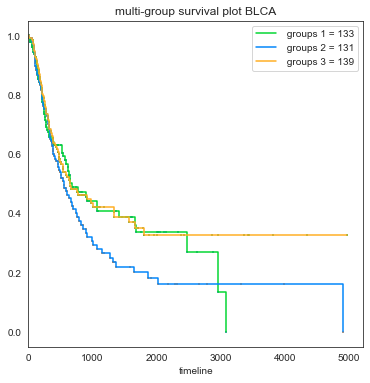

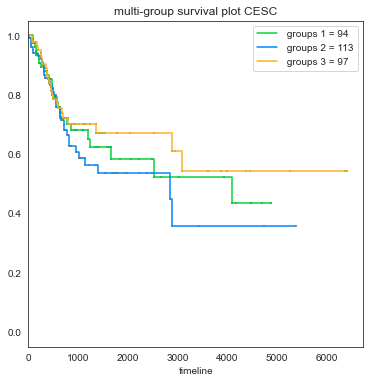

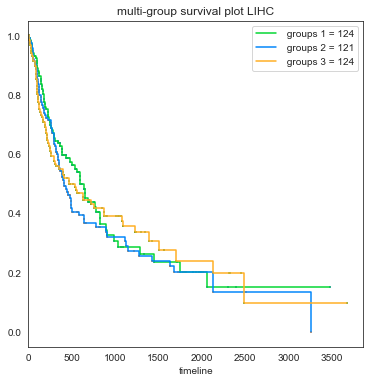

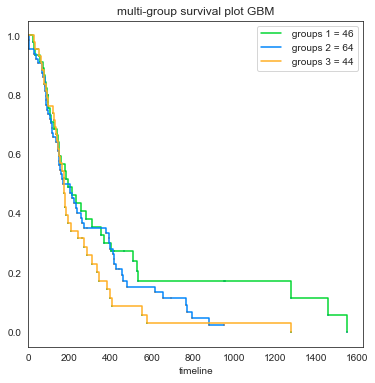

In [18]:
# Supplementary Figure 1

import warnings
warnings.filterwarnings('ignore')

dict_survival = {}
f_dir = "C:/Data/Lab/Zanetti_Lab/Figures/"
disease_list = ["HNSC","non-TNBC","SKCM","READ","LUAD","LUSC","COAD","TNBC","BLCA","CESC","LIHC","GBM"]
for d in disease_list:
    dict_survival[d] = plot_multi_survival_for_scoreinterval(df_score_2_clean,d,[-1,3.5,4.5,6],[1,2,3])
    #plt.savefig(f_dir + "fig1." + d + "survival_score6.pdf",bbox_inches = "tight")

In [19]:
def log_rank_test(T,T2,C,C2):
    from lifelines.statistics import logrank_test
    result = logrank_test(T.astype(np.int), T2.astype(np.int), C.astype(np.int), C2.astype(np.int), alpha=0.95)
    return result

In [20]:
disease_list = ["HNSC","non-TNBC","SKCM","READ","LUAD","LUSC","COAD","TNBC","BLCA","CESC","LIHC","GBM"]
for d in disease_list:
    for i in range(1,3):
        res = log_rank_test(dict_survival[d][0][i],dict_survival[d][0][i+1],
                  dict_survival[d][1][i],dict_survival[d][1][i+1])
        if res.p_value <.05:
            print(f'{d} comparison between {i} and {i+1} p value is {res.p_value}')

HNSC comparison between 2 and 3 p value is 0.03900204433230169
non-TNBC comparison between 2 and 3 p value is 0.02432613066530949
READ comparison between 1 and 2 p value is 0.02798145745938487
READ comparison between 2 and 3 p value is 0.01831193232893574


# Supplementary S2
- Survival for Bhi/TERThi vs BhiTERT lo for other cancer types

In [21]:
def PFSsurvival(Df,gene,diseaseName,time = 3000, save = False,fdir = None):
    """Progression free survival analysis
    @Df: the data frame of input, should contain gene cateogorical variable
    @gene: categorical varialbe of "HIGH" and "LOW" as seperated groups for analysis
    @time: the limitation of time, default is to 3000
    @diseaseName: the name of the disease, usually is a tumor type
    """
    f_dir = "C:/Data/Lab/Zanetti_Lab/HNSC/"
    
    import matplotlib as mtp
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    from lifelines import KaplanMeierFitter
    kmf = KaplanMeierFitter()
    from lifelines.statistics import logrank_test
    mtp.rcParams['pdf.fonttype'] = 42
    
    pfs=pd.read_csv(f_dir + "PFSfile.csv")
    Df=pd.merge(Df,pfs[['patient_id','PFS','PFS.time']],on='patient_id')
    Df.dropna(subset=['PFS.time','PFS'],inplace=True)
    Df = Df[Df["PFS.time"] < time]
    Df.drop_duplicates(inplace=True)
    
    groups = Df[gene]
    high = (groups == 'HIGH')
    low = (groups == 'LOW')

    T = Df['PFS.time'][low]
    T = T.astype(np.int)
    C = Df['PFS'][low]*1
    C = C.astype(np.int)

    T2 = Df['PFS.time'][high]
    T2 = T2.astype(np.int)
    C2 = Df['PFS'][high]*1
    C2 = C2.astype(np.int)

    fig,ax = plt.subplots(figsize = (6,6),sharex=True,sharey=True)
    result_H = kmf.fit(T,C,label= str(gene)+ " low = "+ str(len(Df[Df[gene] == 'LOW'])))
    kmf.plot(ci_show=False,ax =ax )
    ax.scatter(x = 'timeline', y = str(gene)+" low = "+ str(len(Df[Df[gene] == 'LOW'])),
        data = result_H.survival_function_.reset_index(),marker = "|", c = 'blue',
              s = 500)

    result_L = kmf.fit(T2,C2,label = str(gene)+' high = '+ str(len(Df[Df[gene] == 'HIGH'])))
    kmf.plot(ci_show=False,ax =ax )

    ax.scatter(x = 'timeline', y = str(gene)+' high = '+ str(len(Df[Df[gene] == 'HIGH'])),
        data = result_L.survival_function_.reset_index(),marker = "|", c = 'orange',
              s = 500)
    plt.title(diseaseName+' survival plot signature')
    plt.ylim([-.1,1.1])
    if save:
        #f_dir = "C:/Data/Lab/Zanetti_Lab/Figures/"
        plt.savefig(fdir,bbox_inches = "tight")
    result = logrank_test(T.astype(np.int), T2.astype(np.int), C.astype(np.int), C2.astype(np.int), alpha=0.95)
    print(result.p_value)

In [22]:
def survival_plot_bhiterthi(df,disease):
    df = df[Bcell_marker + ["TERT","patient_id"]]
    df = df.groupby("patient_id")[["TERT"] + Bcell_marker].mean()
    
    b_exp = sp.stats.gmean(np.log2(1+df[Bcell_marker]),axis=1)
    b_cat = pd.cut(x = b_exp,bins = [-np.inf,np.quantile(b_exp,q=.3),np.quantile(b_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

    tert_exp = np.log2(1+df["TERT"]).values
    tert_cat = pd.cut(x = tert_exp, bins = [-np.inf,np.quantile(tert_exp,q=.3),np.quantile(tert_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

    low_ids = df[(b_cat == "HIGH") & (tert_cat == "LOW")].index.tolist()
    high_ids = df[(b_cat == "HIGH") & (tert_cat == "HIGH")].index.tolist()
    
    df = df.loc[high_ids + low_ids]
    df["group"] = [ "HIGH" if x in set(high_ids) else "LOW" for x in df.index.tolist()]
    PFSsurvival(df,"group",disease,time=3000,save=False,fdir = None)

0.004800285482359407
0.30863356119263485
0.7006485674933188
0.5007736952907365
0.7849198965249522
0.910203478301066
0.6246809215807776
0.2837780683968124
0.18067426804861764
0.16496937672759238


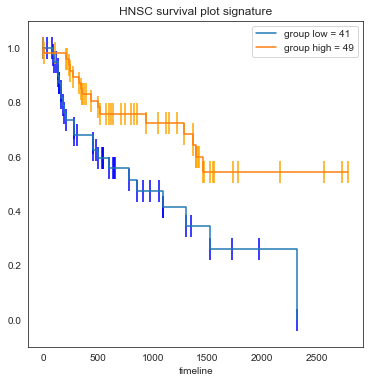

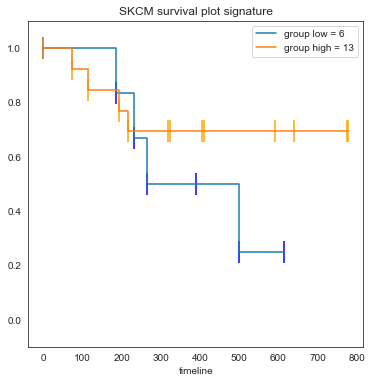

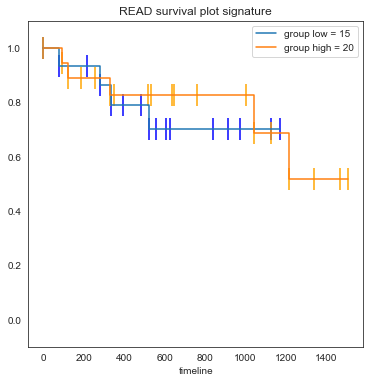

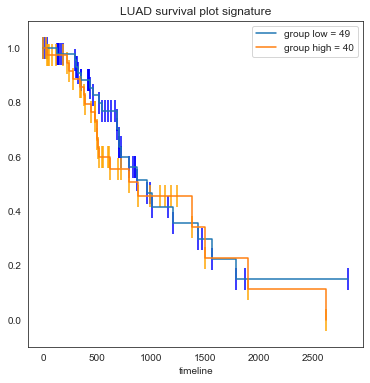

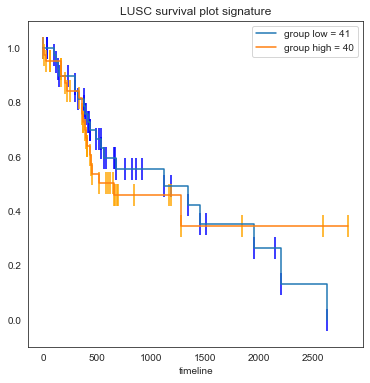

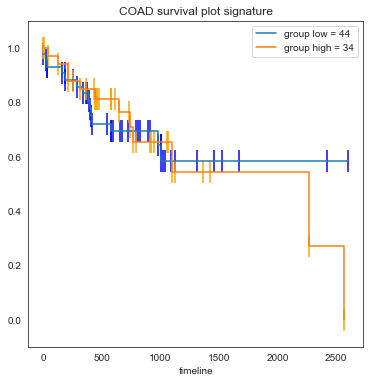

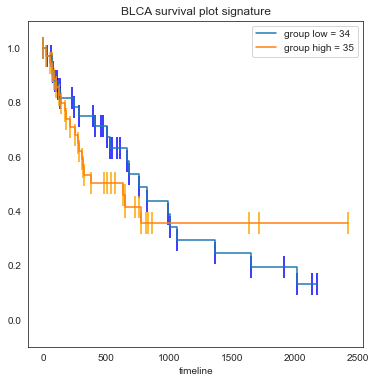

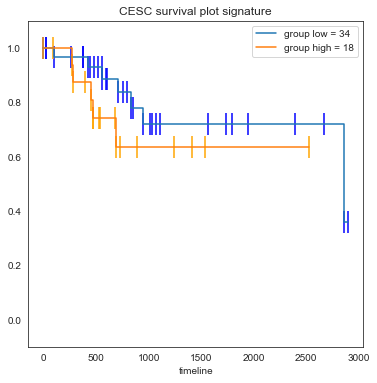

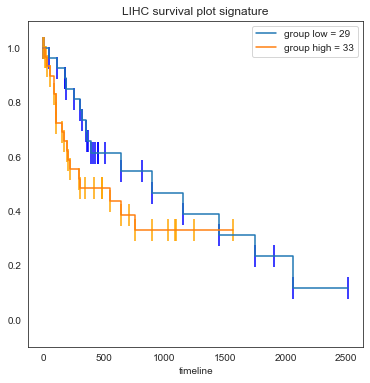

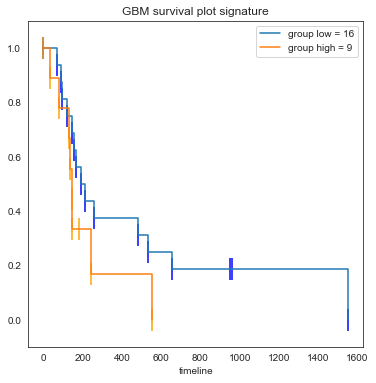

In [23]:
# Supplementary Figure S2
    
import warnings
warnings.filterwarnings('ignore')

tcga_tmp = tcgaDf[["patient_id","disease","TERT"] + Bcell_marker]
disease_list = ["HNSC","SKCM","READ","LUAD","LUSC","COAD","BLCA","CESC","LIHC","GBM"]
sns.set_style("white")
for disease in disease_list:
    # this automatically saves
    survival_plot_bhiterthi(tcga_tmp[tcga_tmp["disease"] == disease],disease = disease)

### TNBC and non-TNBC

In [24]:
# check for BhiTERThi vs BloTERTlo BLCA
def brca_survival_by_subtypes(time = 10000):
    Bcell_marker = ["CD19","MS4A1"]
    disease = "BRCA"
    brca = tcgaDf[tcgaDf["disease"] == disease]
    brca = brca[Bcell_marker + ["TERT","patient_id"]]
    brca = brca.groupby("patient_id")[["TERT"] + Bcell_marker].mean()
    
    tnbc_ids = set(brca_subtype[brca_subtype["tnbc"] == "Positive"]["patient_id"]).intersection(brca.index.tolist())
    non_tnbc_ids = set(brca_subtype[brca_subtype["tnbc"] != "Positive"]["patient_id"]).intersection(brca.index.tolist())
    for ids, savename in zip([tnbc_ids,non_tnbc_ids],["tnbc","non_tnbc"]):
        
        df = brca.loc[list(ids)]
        print(len(df))
        b_exp = sp.stats.gmean(np.log2(1+df[Bcell_marker]),axis=1)
        b_cat = pd.cut(x = b_exp,bins = [-np.inf,np.quantile(b_exp,q=.3),np.quantile(b_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

        tert_exp = np.log2(1+df["TERT"]).values
        tert_cat = pd.cut(x = tert_exp, bins = [-np.inf,np.quantile(tert_exp,q=.3),np.quantile(tert_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

        low_ids = df[(b_cat == "LOW") & (tert_cat == "LOW")].index.tolist()
        high_ids = df[(b_cat == "HIGH") & (tert_cat == "HIGH")].index.tolist()

        df = df.loc[high_ids + low_ids]
        print(df.shape)
        
        df["group"] = [ "HIGH" if x in set(high_ids) else "LOW" for x in df.index.tolist()]
        PFSsurvival(df,"group",disease,time = 10000,save = False,fdir = None)
        #plt.title(typ)

190
(35, 3)
0.8473189792592049
902
(179, 3)
0.044280621969474694


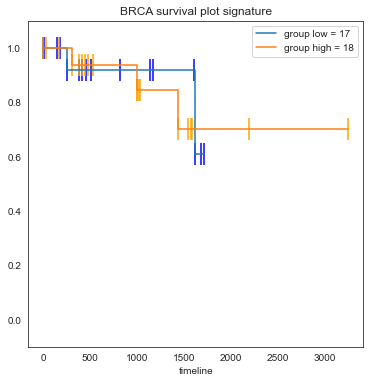

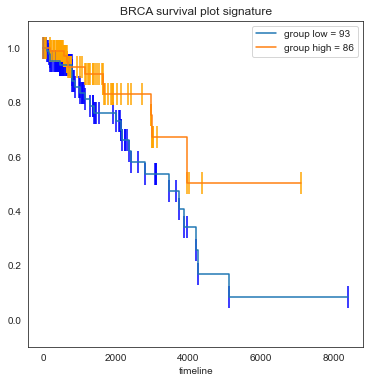

In [25]:
brca_survival_by_subtypes()

# Figure 1B
- quantile plot

In [26]:
import warnings
warnings.filterwarnings('ignore')
def quantile_plot():
    cd3 = ["CD3D","CD3E","CD3G"]
    #cd4 = ["CD3D","CD3E","CD3G","CD4"]
    #cd8 = ["CD3D","CD3E","CD3G","CD8A","CD8B"]
    bcell = ["CD19","MS4A1"]
    cols = ["CD3","Bcell","TERT"]
    d = {"CD3":cd3,
         "Bcell":bcell,
         }
    
    # modify tcgaDf brca
    tcga_quantile = tcgaDf[["patient_id","disease","TERT"] + list(set(cd3 + bcell))]
    def return_brca_subtypes(df):
        tnbc_ids = set(brca_subtype[brca_subtype["tnbc"] == "Positive"]["patient_id"])
        returnlist = []
        for i,row in df.iterrows():
            if row["disease"] == "BRCA":
                if row["patient_id"] in tnbc_ids:
                    returnlist.append("TNBC")
                else:
                    returnlist.append("non-TNBC")
            else:
                returnlist.append(row["disease"])
        return returnlist
    tcga_quantile["disease"] = return_brca_subtypes(tcga_quantile)
    #diseaselist = ["HNSC","BRCA","LUAD","LUSC","CESC","BLCA","SKCM","COAD","LIHC","READ","GBM"]
    disease_list = ["HNSC","non-TNBC","SKCM","READ","LUAD","LUSC","COAD","TNBC","BLCA","CESC","LIHC","GBM"]
    dfplot = pd.DataFrame(columns = ["disease","variable","quantile","value"])
    for disease in disease_list:
        df = tcga_quantile[tcga_quantile.disease == disease]
        dict_imm = {}
        for exp in cols:
            if exp !="TERT":
                val = sp.stats.gmean(np.log2(1+df[d[exp]].apply(pd.to_numeric)),axis=1)
            else:
                val = np.log2(1+df[exp].apply(pd.to_numeric))
            quantiles = [np.quantile(val,q = .3), np.quantile(val,q = .7)]
            dftmp = pd.DataFrame({"disease":[disease] * 2,
                                  "variable":[exp] * 2,
                                  "quantile":[.3,.7],
                                  "value":quantiles})
            dfplot = pd.concat([dfplot,dftmp])
            if exp == "CD3" or exp == "Bcell":
                dict_imm[exp] = val
            
        # all exp done, let cd3 + B cell to be imm
        imm = np.array(dict_imm["CD3"]) + np.array(dict_imm["Bcell"])
        quantiles = [np.quantile(imm,q = .3), np.quantile(imm,q = .7)]
        dftmp = pd.DataFrame({"disease":[disease] * 2,
                                  "variable":["immune"] * 2,
                                  "quantile":[.3,.7],
                                  "value":quantiles})
        dfplot = pd.concat([dfplot,dftmp])
    return dfplot
dfplot_q2 = quantile_plot()

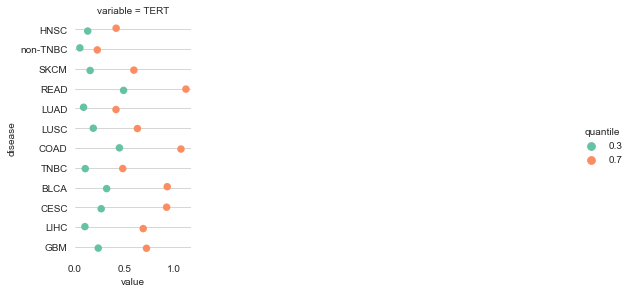

In [27]:
# recale TERT
g = sns.catplot(x="value", col="variable", 
                col_wrap = 4,
                data=dfplot_q2[dfplot_q2["variable"] == "TERT"], y = "disease", hue = "quantile",
                palette = "Set2",
                kind = "strip",
                orient = "h",
                s = 7.5,
                height= 4, aspect=.5)

for ax in g.axes.flat:

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
#plt.savefig(f_dir + "supplement2_TERT.pdf",bbox_inches = "tight")

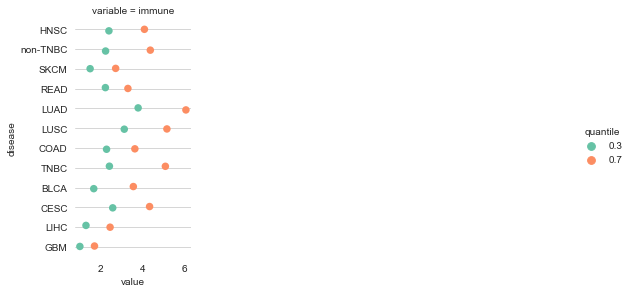

In [28]:
g = sns.catplot(x="value", col="variable", 
                col_wrap = 4,
                data=dfplot_q2[(dfplot_q2["variable"] == "immune")], y = "disease", hue = "quantile",
                palette = "Set2",
                kind = "strip",
                orient = "h",
                s = 7.5,
                height= 4, aspect=.5)

for ax in g.axes.flat:

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
#plt.savefig(f_dir + "supplement2_immune_score.pdf",bbox_inches = "tight")

# Figure 2

0.07934901768056071
2.8098282810112637e-05
0.0016494010659538784
0.006406034622138415


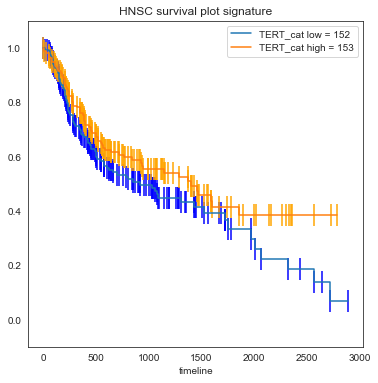

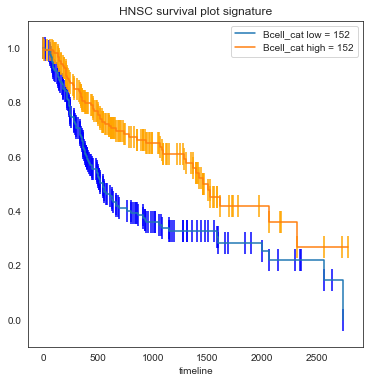

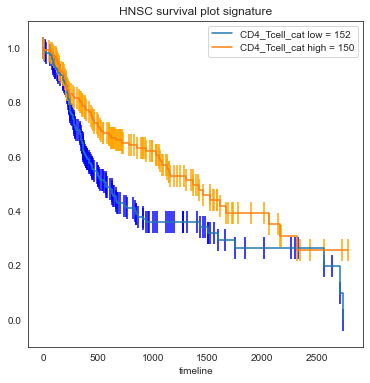

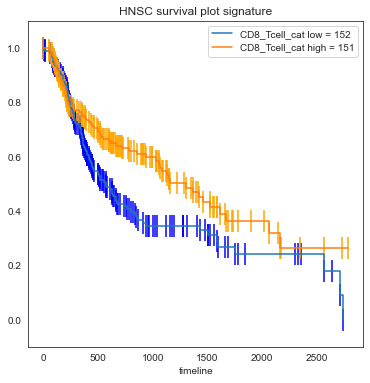

In [29]:
### Panel A
df = tcgaDf[tcgaDf.disease == "HNSC"]
df["TERT"] = np.log2(1+df["TERT"])
df["Bcell"] = sp.stats.gmean(np.log2(1+df[["CD19","MS4A1"]]),axis = 1)
df["CD4_Tcell"] = sp.stats.gmean(np.log2(1+df[["CD3D","CD3E","CD3G","CD4"]]),axis = 1)
df["CD8_Tcell"] = sp.stats.gmean(np.log2(1+df[["CD3D","CD3E","CD3G","CD8A","CD8B"]]),axis = 1)
#print(df.shape)
#print(df.drop_duplicates().shape)

# what should we use? 0 or -1
for cat in ["TERT","Bcell","CD4_Tcell","CD8_Tcell"]:
    df[cat+"_cat"] = pd.cut(df[cat],bins= [-1,df[cat].quantile(q=.3), df[cat].quantile(q=.7), np.inf], labels = ["LOW","MED","HIGH"])
    
for cat in ["TERT_cat","Bcell_cat","CD4_Tcell_cat","CD8_Tcell_cat"]:
    PFSsurvival(df,cat,"HNSC",time = 3000)
    #plt.savefig(DIR+cat+"KM.survival.pdf",bbox_inches = "tight")

0.004800285482359407
0.24502517009251634


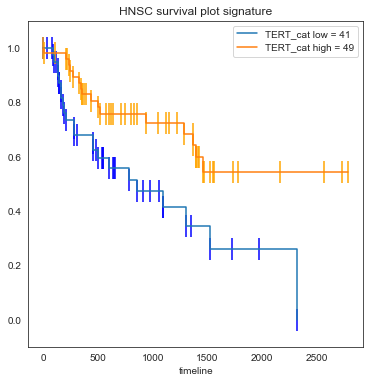

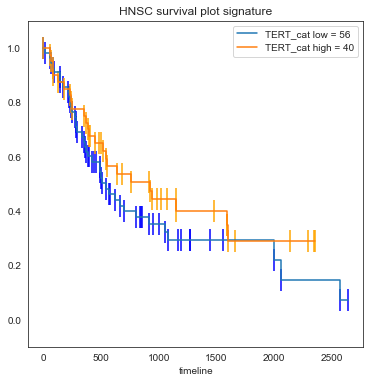

In [30]:
### Panel B
hnsc= tcgaDf[tcgaDf.disease == "HNSC"]

b_exp = sp.stats.gmean(np.log2(1+hnsc[Bcell_marker]),axis=1)
b_cat = pd.cut(x = b_exp,bins = [-np.inf,np.quantile(b_exp,q=.3),np.quantile(b_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

tert_exp = np.log2(1+hnsc["TERT"]).values
tert_cat = pd.cut(x = tert_exp, bins = [-np.inf,np.quantile(tert_exp,q=.3),np.quantile(tert_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

low_ids = hnsc[(b_cat == "HIGH") & (tert_cat == "LOW")]["patient_id"].tolist()
high_ids = hnsc[(b_cat == "HIGH") & (tert_cat == "HIGH")]["patient_id"].tolist()

subdf = tcgaDf[tcgaDf.disease == "HNSC"][["patient_id","CTAG1B","MUC1"]+Bcell_marker]
subdf["b_cat"] = b_cat
subdf["TERT_cat"] = tert_cat
#subdf = subdf[subdf["b_cat"] == "HIGH"]

# BhiTERThi vs BhiTERTlo
PFSsurvival(subdf[subdf["b_cat"] == "HIGH"],"TERT_cat","HNSC")

# BloTERThi vs BloTERTlo
PFSsurvival(subdf[subdf["b_cat"] == "LOW"],"TERT_cat","HNSC")

0.80767499557287
0.48854867148597425
0.711103269559836
0.5746705323054562
0.7540613839883699


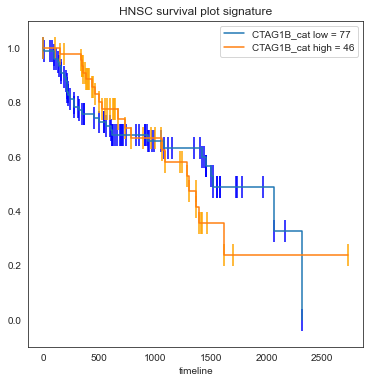

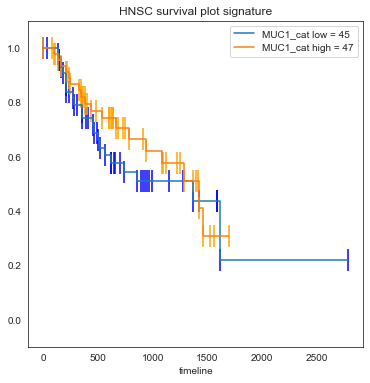

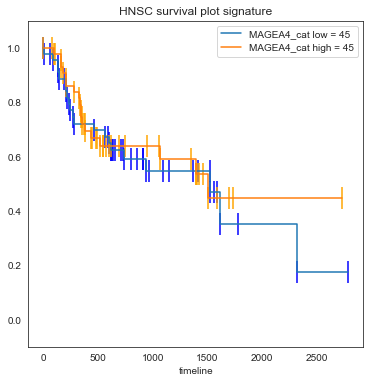

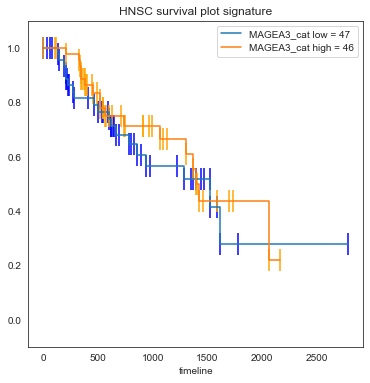

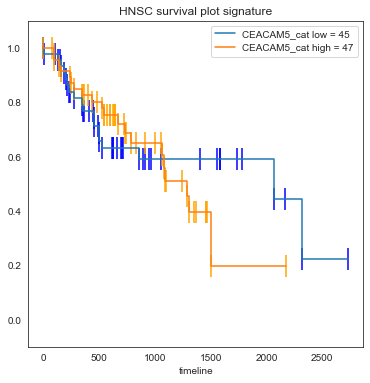

In [31]:
# Panel C

import warnings
warnings.filterwarnings('ignore')

f_dir = "C:/Data/Lab/Zanetti_Lab/HNSC/"

subdf = tcgaDf[tcgaDf.disease == "HNSC"][["patient_id","CTAG1B","MUC1","MAGEA4","MAGEA3","CEACAM5"]+Bcell_marker]
subdf["bcell"] = sp.stats.gmean(np.log(1+subdf[Bcell_marker]),axis=1)
subdf["bcell_cat"] = pd.cut(subdf["bcell"],bins = [-np.inf, np.quantile(subdf["bcell"],q = .3), np.quantile(subdf["bcell"],q = .7), np.inf], labels = ["LOW","MID","HIGH"])
subdf = subdf[subdf["bcell_cat"] == "HIGH"]

for cat in ["CTAG1B","MUC1","MAGEA4","MAGEA3","CEACAM5"]:
    subdf[cat+"_cat"] = pd.cut(subdf[cat],bins= [-1,subdf[cat].quantile(q=.3), subdf[cat].quantile(q=.7), np.inf], labels = ["LOW","MED","HIGH"])
    PFSsurvival(subdf,cat+"_cat","HNSC")
    #plt.savefig(f_dir + cat+".KM.survival.pdf",bbox_inches = "tight")

# Figure  3

In [32]:
hnsc = tcgaDf[tcgaDf.disease == "HNSC"]

In [33]:
hpv_neg_ids_cbioportal = pd.read_csv("C:/Data/Lab/Zanetti_Lab/HNSC/hnsc_tcga_pan_can_atlas_2018_clinical_data.tsv",sep = "\t")
hpv_pos_ids_cbioportal = [ x.split("-")[2] for x in hpv_neg_ids_cbioportal[hpv_neg_ids_cbioportal["Subtype"] == "HNSC_HPV+"]["Patient ID"].tolist()]

RanksumsResult(statistic=4.104396928309489, pvalue=4.053709512401159e-05)


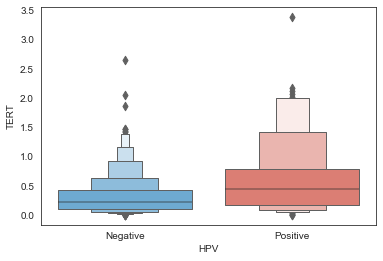

In [34]:
### A
dfplot = pd.DataFrame({"TERT":np.log2(1+hnsc["TERT"]),
                       "HPV":["Positive" if x in hpv_pos_ids_cbioportal else "Negative" for x in hnsc["patient_id"].tolist()]})

sns.boxenplot(x = "HPV", y = "TERT", 
              order = ["Negative","Positive"],
              data = dfplot, palette = {"Positive": "#EC7063",
                                                               "Negative": "#5DADE2"})

print(sp.stats.ranksums(dfplot[dfplot["HPV"] == "Positive"]["TERT"],
                        dfplot[dfplot["HPV"] == "Negative"]["TERT"]))
#plt.savefig("C:/Data/Lab/Zanetti_Lab/Figures/finalize/Figure3/fig3a.pdf",bbox_inches="tight")

<AxesSubplot:xlabel='index', ylabel='HPV_pos'>

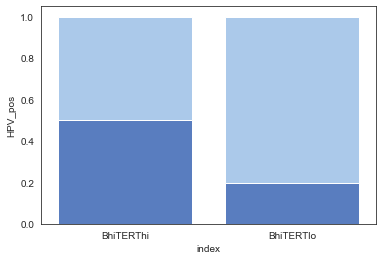

In [35]:
### reproduce B
dfplot = pd.DataFrame(index = ["BhiTERTlo","BhiTERThi"], columns = ["HPV_neg","HPV_pos"],
                      data = np.array([[33,8],[26,26]]))
dfplot["total"] = [41,52]

for i in range(2):
    dfplot.iloc[i] /= dfplot.iloc[i,2]
    
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="index", y="total", 
            order = ["BhiTERThi","BhiTERTlo"],
            data=dfplot.reset_index(),
            color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="index", y="HPV_pos", 
            order = ["BhiTERThi","BhiTERTlo"],
            data=dfplot.reset_index(),
            color="b")

#plt.legend(["hpv_negative", "hpv_positive"])

#plt.savefig("C:/Data/Lab/Zanetti_Lab/Figures/finalize/Figure3/fig3b.pdf",bbox_inches="tight")

In [36]:
sp.stats.fisher_exact(np.array([[33,8],[26,26]]).T)

(4.125, 0.0026677141399814143)

0.008914617645254839


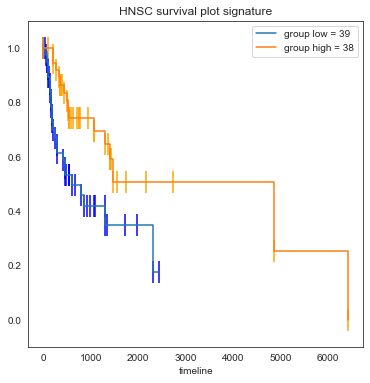

In [37]:
### reproduce C
def plot_panel_c(df = hnsc):
    df = df[Bcell_marker + ["TERT","patient_id"]]
    df = df.groupby("patient_id")[["TERT"] + Bcell_marker].mean()
    
    b_exp = sp.stats.gmean(np.log2(1+df[Bcell_marker]),axis=1)
    b_cat = pd.cut(x = b_exp,bins = [-np.inf,np.quantile(b_exp,q=.3),np.quantile(b_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

    tert_exp = np.log2(1+df["TERT"]).values
    tert_cat = pd.cut(x = tert_exp, bins = [-np.inf,np.quantile(tert_exp,q=.3),np.quantile(tert_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

    low_ids = df[(b_cat == "HIGH") & (tert_cat == "LOW")].index.tolist()
    high_ids = df[(b_cat == "HIGH") & (tert_cat == "HIGH")].index.tolist()
    
    df = df.loc[high_ids + low_ids]
    df["group"] = [ "HIGH" if x in set(high_ids) else "LOW" for x in df.index.tolist()]
    PFSsurvival(df,"group","HNSC",time=10000,save=False,fdir = "C:/Data/Lab/Zanetti_Lab/Figures/finalize/Figure3/fig3c.pdf")
    
_ids = set(hnsc["patient_id"]).difference(hpv_pos_ids_cbioportal)
hnsc_hpv_neg = hnsc.set_index("patient_id").loc[_ids].reset_index()

plot_panel_c(df = hnsc_hpv_neg)

0.23241478601855617


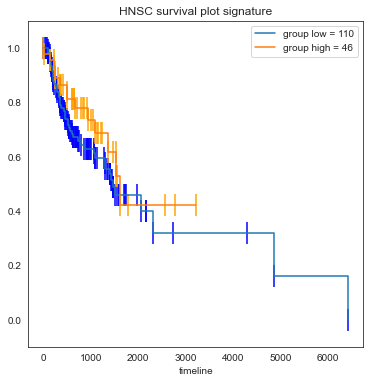

In [38]:
### reproduce D
def plot_panel_d(df = hnsc):
    df = df[Bcell_marker + ["TERT","patient_id"]]
    df = df.groupby("patient_id")[["TERT"] + Bcell_marker].mean()
    
    b_exp = sp.stats.gmean(np.log2(1+df[Bcell_marker]),axis=1)
    b_cat = pd.cut(x = b_exp,bins = [-np.inf,np.quantile(b_exp,q=.3),np.quantile(b_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

    tert_exp = np.log2(1+df["TERT"]).values
    tert_cat = pd.cut(x = tert_exp, bins = [-np.inf,np.quantile(tert_exp,q=.3),np.quantile(tert_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

    #low_ids = df[(b_cat == "LOW")].index.tolist()
    high_ids = df[(b_cat == "HIGH")].index.tolist()
    
    df = df.loc[high_ids].reset_index()
    df["group"] = ["HIGH" if x in set(hpv_pos_ids_cbioportal) else "LOW" for x in df["patient_id"].tolist()]
    
    #df["group"] = [ "HIGH" if x in set(high_ids) else "LOW" for x in df.index.tolist()]
    PFSsurvival(df,"group","HNSC",time=10000,save=False,fdir = "C:/Data/Lab/Zanetti_Lab/Figures/finalize/Figure3/fig3d.pdf")

plot_panel_d(hnsc)

# Table 1

In [39]:
def cox_p_analysis_global_t_cell(df,include_stage = False,plot = False, save = False):
    
    from lifelines import CoxPHFitter
    cph = CoxPHFitter()

    """@DIR is a global variable"""
    f_dir = "C:/Data/Lab/Zanetti_Lab/HNSC/"
    pfs = pd.read_csv(f_dir + "PFSfile.csv")
    clinic = pd.read_csv(f_dir + "clinical.csv")
    clinic.rename(columns = {"Unnamed: 0":"patient_id"},inplace = True)
    clinic["patient_id"] = [ x.split("-")[2] for x in clinic["patient_id"]]
    
    # get log Tumor mutation burden
    allmaf = pd.read_csv(f_dir + "all.maf",header = None, sep = "\t")
    tmb = pd.DataFrame(allmaf[0].value_counts())
    tmb.index = [ x.split("-")[2] for x in tmb.index.tolist()]
    tmb.reset_index(inplace = True)
    tmb.columns = ["patient_id","mutCount"]
    tmb["logTMB"] = np.log(1 + tmb["mutCount"])
    
    df = pd.merge(df,pfs[["patient_id","PFS.time","PFS"]], on = "patient_id")
    df = pd.merge(df,clinic[["patient_id","Sex","Age"]], on = "patient_id")
    df = pd.merge(df,tmb[["patient_id","logTMB"]], on = "patient_id")
    df["Sex"] = [1 if x == "Male" else 0 for x in df.Sex.tolist()]
    df.dropna(inplace = True)
    df.drop_duplicates(inplace = True)
    df.dropna()
    print(df.shape)
    
    df["hpv"] = [1 if x in hpv_pos_ids_cbioportal else 0 for x in df["patient_id"].tolist()]
    # if include stage:

    if include_stage:
        stage_dict = {"Stage I":1,"Stage II":2, "Stage III":3, "Stage IV":4}
        stage = pd.read_csv(f_dir + "stageinfo.csv",header = None)
        stage.columns = ["patient_id","stage"]
        df = pd.merge(df, stage, on = "patient_id").drop_duplicates()
        df["stage"] = [stage_dict[x] if x in stage_dict.keys() else np.nan for x in df["stage"].tolist()]
        cph.fit(df[["PFS.time","PFS","Age","Sex","TERT","cd8","cd4","bcell","logTMB","stage","hpv","Bcell*TERT"]].dropna(), 'PFS.time', event_col='PFS')
        cph.print_summary()
    else:
        cph.fit(df[["bcell","logTMB","cd8","cd4","PFS.time","PFS","Age","Sex","TERT","hpv"]], 'PFS.time', event_col='PFS')
        cph.print_summary()
        
    if plot:
        save_dir = "C:/Data/Lab/Zanetti_Lab/Figures/"
        cph.plot()
        if save:
            if include_stage:
                plt.savefig(save_dir+".cph.stage.plot.pdf", bbox_inches = "tight")
            else:
                plt.savefig(save_dir+".cph.plot.pdf", bbox_inches = "tight")

In [40]:
cd4 = ["CD3D","CD3E","CD3G","CD4"]
cd8 = ["CD3D","CD3E","CD3G","CD8A","CD8B"]
bcell = ["CD19","MS4A1"]
cd3 = ["CD3D","CD3E","CD3G"]

df = hnsc[list(set(cd3 + bcell + cd4 + cd8)) + ["TERT","patient_id"]]
df["cd3"] = sp.stats.gmean(np.log2(1+df[cd3]),axis=1)
df["bcell"] = sp.stats.gmean(np.log2(1+df[bcell]),axis=1)
df["cd4"] = sp.stats.gmean(np.log2(1+df[cd4]),axis=1)
df["cd8"] = sp.stats.gmean(np.log2(1+df[cd8]),axis=1)
df["TERT"] = np.log2(1+df["TERT"])

# interaction term B*TERT
df["Bcell*TERT"] = df["bcell"] * df["TERT"]

(499, 20)


<lifelines.CoxPHFitter: fitted with 377 total observations, 182 right-censored observations>
             duration col = 'PFS.time'
                event col = 'PFS'
      baseline estimation = breslow
   number of observations = 377
number of events observed = 195
   partial log-likelihood = -1000.40
         time fit was run = 2022-09-01 17:21:05 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
Age          0.01       1.01       0.01             0.00             0.03                 1.00                 1.03
Sex         -0.14       0.87       0.17            -0.47             0.18                 0.63                 1.20
TERT        -0.22       0.80       0.32            -0.84             0.40                 0.43                 1.50
cd8          0.36       1.44       0.31            -0.25             0.98                 0.78                 2.67
cd4         -0.57       0.56       0.41            -1.37             0.23                 0.25                 1.26
bcell       -0.11       0.89       0.19            -0.48             0.26                 0.62                 1.29
logTMB      -0.13       0.88       0.10            -0.33             0.07                 0.72                 1.07
stage        0.30       1.35       0.09             0.14             0.47                 1.15                 1.60
hpv         -0.31       0.73       0.28            -0.87             0.24                 0.42                 1.27
Bcell*TERT  -0.42       0.66       0.38            -1.16             0.33                 0.31                 1.39

               z      p   -log2(p)
covariate                         
Age         2.10   0.04       4.82
Sex        -0.87   0.39       1.37
TERT       -0.69   0.49       1.02
cd8         1.16   0.25       2.02
cd4        -1.40   0.16       2.63
bcell      -0.60   0.55       0.87
logTMB     -1.30   0.19       2.38
stage       3.56 <0.005      11.37
hpv        -1.11   0.27       1.91
Bcell*TERT -1.10   0.27       1.87
---
Concordance = 0.63
Partial AIC = 2020.79
log-likelihood ratio test = 47.82 on 10 df
-log2(p) of ll-ratio test = 20.51

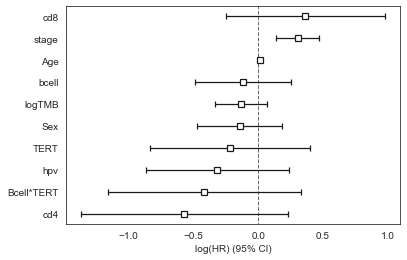

In [41]:
# interaction term
cox_p_analysis_global_t_cell(df,plot = True, include_stage = True,save = False)

(499, 20)


<lifelines.CoxPHFitter: fitted with 377 total observations, 182 right-censored observations>
             duration col = 'PFS.time'
                event col = 'PFS'
      baseline estimation = breslow
   number of observations = 377
number of events observed = 195
   partial log-likelihood = -1000.40
         time fit was run = 2022-09-01 17:21:12 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
Age          0.01       1.01       0.01             0.00             0.03                 1.00                 1.03
Sex         -0.14       0.87       0.17            -0.47             0.18                 0.63                 1.20
TERT        -0.22       0.80       0.32            -0.84             0.40                 0.43                 1.50
cd8          0.36       1.44       0.31            -0.25             0.98                 0.78                 2.67
cd4         -0.57       0.56       0.41            -1.37             0.23                 0.25                 1.26
bcell       -0.11       0.89       0.19            -0.48             0.26                 0.62                 1.29
logTMB      -0.13       0.88       0.10            -0.33             0.07                 0.72                 1.07
stage        0.30       1.35       0.09             0.14             0.47                 1.15                 1.60
hpv         -0.31       0.73       0.28            -0.87             0.24                 0.42                 1.27
Bcell*TERT  -0.42       0.66       0.38            -1.16             0.33                 0.31                 1.39

               z      p   -log2(p)
covariate                         
Age         2.10   0.04       4.82
Sex        -0.87   0.39       1.37
TERT       -0.69   0.49       1.02
cd8         1.16   0.25       2.02
cd4        -1.40   0.16       2.63
bcell      -0.60   0.55       0.87
logTMB     -1.30   0.19       2.38
stage       3.56 <0.005      11.37
hpv        -1.11   0.27       1.91
Bcell*TERT -1.10   0.27       1.87
---
Concordance = 0.63
Partial AIC = 2020.79
log-likelihood ratio test = 47.82 on 10 df
-log2(p) of ll-ratio test = 20.51

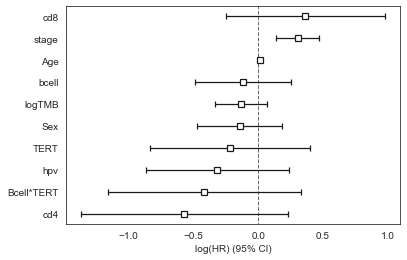

In [42]:
cox_p_analysis_global_t_cell(df,plot = True, include_stage = True,save = False)

# Fig4 TLS in whole and HPV-

In [43]:
hnsc_cibersort = pd.read_csv("C:/Data/Lab/Zanetti_Lab/data/cibersort/HNSC.out.csv")
hnsc_cibersort.rename(columns = {"Input Sample":"patient_id"}, inplace =True)

In [44]:
def colormap(idslist):
    mappings = []
    for ids in idslist:
        if ids in low_ids:
            mappings.append("#229954")
        elif ids in high_ids:
            mappings.append("#F1C40F")
        else:
            mappings.append("gray")
    return mappings

SpearmanrResult(correlation=0.26673671655072967, pvalue=1.5765377296984892e-07)
Ttest_indResult(statistic=4.333290193643118, pvalue=6.584559074051502e-05)


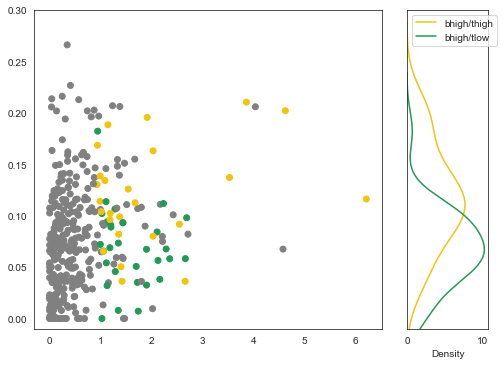

In [45]:
# HPV NEG
figure, axes = plt.subplots(1, 2, sharey = True,
                            figsize=(7, 5),gridspec_kw={'width_ratios': [3, .7]})

figure.tight_layout()

idx = list(set(hnsc_cibersort["patient_id"]).intersection(hnsc["patient_id"]).difference(hpv_pos_ids_cbioportal))
#v1 = np.mean(np.log2(1+hnsc.set_index("patient_id").loc[idx][tfh_genes]),axis=1)
v2 = sp.stats.gmean(np.log2(1+hnsc.set_index("patient_id").loc[idx][bcell]),axis=1)

dfplot = pd.DataFrame({"Bcell signature":v2,
                       "T cells follicular helper %":hnsc_cibersort.set_index("patient_id").loc[idx]["T cells follicular helper"],
                       "hue":colormap(idx)})

# axes 1
sns.kdeplot(dfplot[dfplot["hue"] == "#F1C40F"]["T cells follicular helper %"],color = "#F1C40F",vertical = True, ax= axes[1], label = "bhigh/thigh")
sns.kdeplot(dfplot[dfplot["hue"] == "#229954"]["T cells follicular helper %"],color = "#229954",vertical = True,ax = axes[1], label = "bhigh/tlow")

# axes 0

axes[0].scatter(v2,hnsc_cibersort.set_index("patient_id").loc[idx]["T cells follicular helper"],c = colormap(idx))
#plt.subplot(Grid_plot[1, :2],)
#plt.subplot(Grid_plot[1, 2])
axes[0].set_ylim([-0.01,0.3])
axes[1].legend()
#plt.savefig(save_dir + "tls_bcell.pdf",bbox_inches="tight")

print(sp.stats.spearmanr(dfplot["Bcell signature"],
                   dfplot["T cells follicular helper %"]))


print(sp.stats.ttest_ind(dfplot[dfplot["hue"] == "#F1C40F"]["T cells follicular helper %"].tolist(),
                 dfplot[dfplot["hue"] == "#229954"]["T cells follicular helper %"].tolist()))

In [46]:
# MUC1
# Bhi Thi vs Blow Thi:
def plot_tfh_distribution(gene,savefig = False, hpv_negative_only = False):
    """requires global HNSC"""
    gene_exp = hnsc[gene].tolist()
    gene_cat = pd.cut(x = gene_exp,bins = [-np.inf,np.quantile(gene_exp,q=.3),np.quantile(gene_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])
    
    b_exp = sp.stats.gmean(np.log2(1+hnsc[Bcell_marker]),axis=1)
    b_cat = pd.cut(x = b_exp,bins = [-np.inf,np.quantile(b_exp,q=.3),np.quantile(b_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

    
    low_ids = hnsc[(b_cat == "HIGH") & (gene_cat == "LOW")]["patient_id"].tolist()
    high_ids = hnsc[(b_cat == "HIGH") & (gene_cat == "HIGH")]["patient_id"].tolist()
    
    idx = list(set(hnsc_cibersort["patient_id"]).intersection(hnsc["patient_id"]))
    low_ids = list(set(low_ids).intersection(idx))
    high_ids = list(set(high_ids).intersection(idx))

    dfplot = pd.DataFrame({"tfh":hnsc_cibersort.set_index("patient_id").loc[low_ids+high_ids]["T cells follicular helper"],
                           "pid":["bhigh/tlow"] * len(low_ids) + ["bhigh/thigh"]*len(high_ids)})

#     #sns.swarmplot(x = "pid",y = "scna",data=dfplot,palette = "Set2")
#     plt.figure(figsize = (3,4))
#     sns.boxplot(x = "pid",y = "tfh",
#                 data = dfplot,
#                 palette = "Set2")
#     plt.title("cibersort")
#     #plt.savefig(save_dir + "bhigh_terthigh_vs_bhigh_tertlow.pdf",bbox_inches="tight")

#     print(sp.stats.ttest_ind(dfplot[dfplot["pid"] == "bhigh/tlow"]["tfh"].tolist(),
#                      dfplot[dfplot["pid"] == "bhigh/thigh"]["tfh"].tolist()))

    figure, axes = plt.subplots(1, 2, sharey = True,
                                figsize=(7, 5),gridspec_kw={'width_ratios': [3, .7]})

    figure.tight_layout()
    
    if hpv_negative_only:
        idx = list(set(hnsc_cibersort["patient_id"]).intersection(hnsc["patient_id"]).difference(hpv_pos_ids_cbioportal))
    else:
        idx = list(set(hnsc_cibersort["patient_id"]).intersection(hnsc["patient_id"]))
    #v1 = np.mean(np.log2(1+hnsc.set_index("patient_id").loc[idx][tfh_genes]),axis=1)
    v2 = sp.stats.gmean(np.log2(1+hnsc.set_index("patient_id").loc[idx][bcell]),axis=1)
    
    def colormap(idslist):
        mappings = []
        for ids in idslist:
            if ids in low_ids:
                mappings.append("#229954")
            elif ids in high_ids:
                mappings.append("#F1C40F")
            else:
                mappings.append("gray")
        return mappings

    dfplot = pd.DataFrame({"Bcell signature":v2,
                           "T cells follicular helper %":hnsc_cibersort.set_index("patient_id").loc[idx]["T cells follicular helper"],
                           "hue":colormap(idx)})

    # axes 1
    sns.kdeplot(dfplot[dfplot["hue"] == "#F1C40F"]["T cells follicular helper %"],color = "#F1C40F",vertical = True, ax= axes[1], label = "bhigh/thigh")
    sns.kdeplot(dfplot[dfplot["hue"] == "#229954"]["T cells follicular helper %"],color = "#229954",vertical = True,ax = axes[1], label = "bhigh/tlow")

    # axes 0

    axes[0].scatter(v2,hnsc_cibersort.set_index("patient_id").loc[idx]["T cells follicular helper"],c = colormap(idx))
    #plt.subplot(Grid_plot[1, :2],)
    #plt.subplot(Grid_plot[1, 2])
    axes[0].set_ylim([-0.01,0.3])
    axes[1].legend()
    
    if savefig:
        save_dir = "C:/Data/Lab/Zanetti_Lab/Figures/finalize/Figure4/"
        if hpv_negative_only:
            plt.savefig(save_dir + gene +"_tls_bcell_hpv_neg.pdf",bbox_inches="tight")
        else:
            plt.savefig(save_dir + gene +"_tls_bcell.pdf",bbox_inches="tight")

    print(sp.stats.spearmanr(dfplot["Bcell signature"],
                       dfplot["T cells follicular helper %"]))

#F1C40F
    print(sp.stats.ttest_ind(dfplot[dfplot["hue"] == "#F1C40F"]["T cells follicular helper %"].tolist(),
                     dfplot[dfplot["hue"] == "#229954"]["T cells follicular helper %"].tolist()))

SpearmanrResult(correlation=0.26673671655072967, pvalue=1.5765377296984892e-07)
Ttest_indResult(statistic=1.5724214535046763, pvalue=0.12270657307918022)


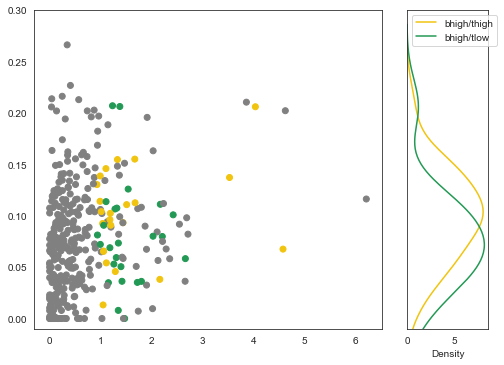

In [47]:
plot_tfh_distribution("MUC1",savefig = True, hpv_negative_only = True)

SpearmanrResult(correlation=0.3431651789447391, pvalue=1.241382241533238e-13)
Ttest_indResult(statistic=5.293792476372641, pvalue=9.61423490925548e-07)


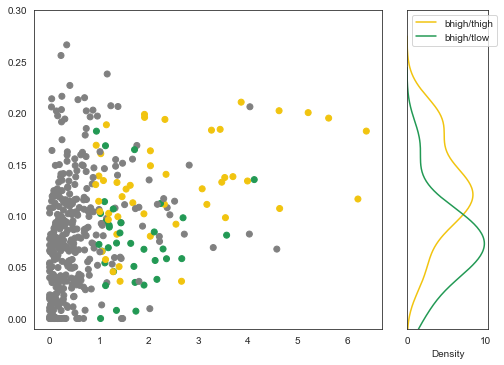

In [48]:
plot_tfh_distribution("TERT",savefig = True, hpv_negative_only = False)

SpearmanrResult(correlation=0.26673671655072967, pvalue=1.5765377296984892e-07)
Ttest_indResult(statistic=4.333290193643118, pvalue=6.584559074051502e-05)


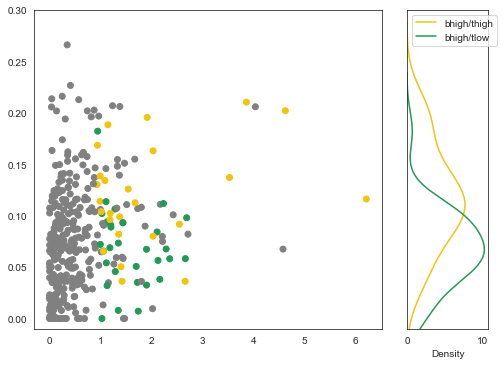

In [49]:
plot_tfh_distribution("TERT",savefig = True, hpv_negative_only = True)